https://radimrehurek.com/gensim/models/word2vec.html

https://rare-technologies.com/word2vec-tutorial/

In [1]:
%%time
import pandas as pd
import dataframe_image as dfi

from gensim.models import Word2Vec

import spacy

nlp = spacy.load("en_core_web_md")
nlp.add_pipe('merge_entities', after = 'ner')
display(pd.DataFrame({'spaCy pipeline components': nlp.pipe_names}).T)

,0,1,2,3,4,5,6
spaCy pipeline components,tok2vec,tagger,parser,attribute_ruler,lemmatizer,ner,merge_entities


CPU times: user 4.29 s, sys: 1.43 s, total: 5.72 s
Wall time: 20 s


In [2]:
%%time

import datetime
import os

def get_dataset_dirpath(cwd):
    
    two_up = os.path.dirname(os.path.dirname(cwd))
    
    return os.path.join(two_up, 'dataset')

dataset_dirpath = get_dataset_dirpath(os.getcwd())

binladenpath = os.path.join(dataset_dirpath, 'Osama bin Laden/')
bushpath = os.path.join(dataset_dirpath, 'George Bush/')


Bush_FileList = [
    '20010914-Remarks at the National Day of Prayer & Remembrance Service.txt',
    '20010915-First Radio Address following 911.txt',
    '20010917-Address at Islamic Center of Washington, D.C..txt',
    '20010920-Address to Joint Session of Congress Following 911 Attacks.txt',
    '20010911-911 Address to the Nation.txt',
    '20011007-Operation Enduring Freedom in Afghanistan Address to the Nation.txt',
    '20011011-911 Pentagon Remembrance Address.txt',
    '20011011-Prime Time News Conference on War on Terror.txt',
    '20011026-Address on Signing the USA Patriot Act of 2001.txt',
    '20011110-First Address to the United Nations General Assembly.txt',
    '20011211-Address to Citadel Cadets.txt',
    '20011211-The World Will Always Remember 911.txt',
    '20020129-First (Official) Presidential State of the Union Address.txt'
]

text = ''

raw = ""
for file in Bush_FileList:
    with open(os.path.join(bushpath, file), 'r') as text:
        raw = raw + text.read()
        
print(f'doc length: {len(raw)}')

doc length: 111934
CPU times: user 1.72 ms, sys: 2.26 ms, total: 3.98 ms
Wall time: 56.2 ms


# Pre-Process text using spaCy

https://www.analyticsvidhya.com/blog/2021/06/must-known-techniques-for-text-preprocessing-in-nlp/

In [3]:
import string
from typing import List
from spacy.tokens import Doc

def create_doc_array(doc: Doc) -> List:    
    
    doc_array = []
    
    for sent in doc.sents:
        
        sent_array = []
        
        for token in sent:
            
            if token.is_punct:
                continue

            if token.is_stop:
                continue

            if token.is_space:
                continue

            if '\n' in token.text:
                continue
                
            text = token.lemma_.lower()
                
            text = text.translate(str.maketrans('', '', string.punctuation))
        
            sent_array.append(text)
                        
        yield sent_array

doc = nlp(raw)
doc_array = create_doc_array(doc)

data = {
    'Original': [sent.text for sent in list(doc.sents)[0:4]],
    'Pre-Processed': [' '.join([token for token in sent]) for sent in list(doc_array)[0:4]]
}

display(pd.DataFrame(data))


,Original,Pre-Processed
0,We are here in the middle hour of our grief.,the middle hour grief
1,"So many have suffered so great a loss, and tod...",suffer great loss today express nation sorrow
2,We come before God to pray for the missing and...,come god pray missing dead love
3,"On Tuesday, our country was attacked with deli...",tuesday country attack deliberate massive cruelty


# Create word2vec model

In [4]:
%%time
from gensim.test.utils import common_texts
from gensim.models import Word2Vec

doc_array = list(create_doc_array(doc))
model = Word2Vec(sentences=doc_array, vector_size=500, window=5, min_count=1, workers=4, sg=1)

def most_similar_terms(seed_terms):
    
    data = {}
    
    for seed_term in seed_terms:
        try:
            data[seed_term] = [f'{sim[0].title()}, ({round(sim[1], 3)})' for sim in model.wv.most_similar(seed_term.lower(), topn=10)]
        except:
            print(f'{seed_term} not in vocab')
            pass
        
    return pd.DataFrame(data)
    
seed_terms_good = ['friend', 'good']
seed_terms_bad = ['enemy', 'terrorist', 'terror', 'bad', 'evil', 'murder']
seed_terms = seed_terms_good + seed_terms_bad
df = most_similar_terms(seed_terms)
display(df)
dfi.export(df, 'seed_terms.png')

,friend,good,enemy,terrorist,terror,bad,evil,murder
0,"America, (0.987)","Terrorist, (0.991)","Terrorist, (0.99)","Military, (0.993)","Terrorist, (0.992)","New, (0.919)","Terrorist, (0.987)","Military, (0.986)"
1,"Terrorist, (0.986)","New, (0.991)","Military, (0.989)","New, (0.993)","Military, (0.991)","America, (0.918)","Terror, (0.986)","New, (0.985)"
2,"New, (0.986)","Great, (0.991)","Help, (0.988)","Work, (0.993)","New, (0.991)","Great, (0.916)","America, (0.986)","Terrorist, (0.985)"
3,"Country, (0.986)","Work, (0.99)","Work, (0.988)","America, (0.993)","America, (0.991)","Terror, (0.916)","Military, (0.985)","America, (0.985)"
4,"Nation, (0.985)","Nation, (0.99)","New, (0.988)","Help, (0.993)","Country, (0.99)","Regime, (0.916)","Country, (0.985)","Weapon, (0.985)"
5,"Great, (0.985)","Military, (0.99)","America, (0.988)","Nation, (0.992)","Help, (0.99)","Work, (0.916)","New, (0.985)","World, (0.984)"
6,"World, (0.985)","Country, (0.99)","Nation, (0.988)","Great, (0.992)","Nation, (0.99)","Act, (0.915)","Help, (0.985)","Act, (0.984)"
7,"Military, (0.985)","Security, (0.99)","Security, (0.988)","Country, (0.992)","Weapon, (0.99)","Government, (0.915)","Work, (0.985)","Great, (0.984)"
8,"Help, (0.985)","Help, (0.99)","Great, (0.987)","Terror, (0.992)","Work, (0.99)","Terrorist, (0.915)","World, (0.984)","Terror, (0.984)"
9,"People, (0.985)","America, (0.99)","Good, (0.987)","Act, (0.992)","Act, (0.99)","Law, (0.915)","Great, (0.984)","Good, (0.984)"


objc[89103]: Class WebSwapCGLLayer is implemented in both /System/Library/Frameworks/WebKit.framework/Versions/A/Frameworks/WebCore.framework/Versions/A/Frameworks/libANGLE-shared.dylib (0x7ffb5e134ec8) and /Applications/Google Chrome.app/Contents/Frameworks/Google Chrome Framework.framework/Versions/105.0.5195.125/Libraries/libGLESv2.dylib (0x11243ae08). One of the two will be used. Which one is undefined.
[1010/123736.256627:INFO:headless_shell.cc(660)] Written to file /var/folders/1f/_bmdf7fs74g5yl2_4y7kq6_m0000gq/T/tmpcuol1c36/temp.png.


CPU times: user 1.18 s, sys: 443 ms, total: 1.62 s
Wall time: 3.75 s


In [5]:
outgroups = ['al Qaeda', 'Taliban', 'Usama bin Laden', 'the Egyptian Islamic Jihad', 'the Islamic Movement of Uzbekistan', 'North Korea', 'Iran', 'Iraq', 'axis of evil']
df = most_similar_terms(outgroups)
display(df)
dfi.export(df, 'outgroup_terms.png')

axis of evil not in vocab


,al Qaeda,Taliban,Usama bin Laden,the Egyptian Islamic Jihad,the Islamic Movement of Uzbekistan,North Korea,Iran,Iraq
0,"Terrorist, (0.973)","Terrorist, (0.988)","Government, (0.452)","Health, (0.354)","Account, (0.262)","Feel, (0.281)","Police, (0.589)","Hold, (0.491)"
1,"Country, (0.971)","America, (0.986)","Woman, (0.448)","Agent, (0.35)","Communication, (0.257)","Prevail, (0.277)","America, (0.582)","Communication, (0.49)"
2,"Terror, (0.971)","Military, (0.986)","Strike, (0.448)","Demand, (0.35)","Patient, (0.252)","Soldier, (0.272)","Child, (0.581)","Priority, (0.487)"
3,"America, (0.971)","Nation, (0.986)","Islam, (0.447)","Encourage, (0.349)","Grateful, (0.25)","Forget, (0.268)","Enemy, (0.58)","Strength, (0.487)"
4,"Work, (0.97)","Help, (0.985)","Thank, (0.446)","Commitment, (0.348)","Thousand, (0.25)","The United Nations, (0.264)","War, (0.58)","Law, (0.486)"
5,"Military, (0.97)","Great, (0.985)","Change, (0.446)","Direct, (0.347)","Look, (0.248)","Right, (0.264)","Good, (0.58)","Protect, (0.485)"
6,"New, (0.97)","Country, (0.985)","Party, (0.446)","Strengthen, (0.346)","Training, (0.247)","Police, (0.262)","Need, (0.58)","Patient, (0.484)"
7,"Great, (0.97)","New, (0.985)","Cause, (0.445)","America, (0.344)","Action, (0.247)","Liberty, (0.26)","Work, (0.579)","Leader, (0.483)"
8,"Weapon, (0.97)","Security, (0.985)","Justice, (0.445)","Agency, (0.344)","Respond, (0.247)","Muslims, (0.26)","Threat, (0.579)","Help, (0.483)"
9,"Good, (0.97)","People, (0.985)","Security, (0.445)","Let, (0.343)","Tragedy, (0.246)","Mean, (0.259)","Security, (0.579)","Afghanistan, (0.482)"


objc[89127]: Class WebSwapCGLLayer is implemented in both /System/Library/Frameworks/WebKit.framework/Versions/A/Frameworks/WebCore.framework/Versions/A/Frameworks/libANGLE-shared.dylib (0x7ffb5e134ec8) and /Applications/Google Chrome.app/Contents/Frameworks/Google Chrome Framework.framework/Versions/105.0.5195.125/Libraries/libGLESv2.dylib (0x10ea0ce08). One of the two will be used. Which one is undefined.
[1010/123737.593396:INFO:headless_shell.cc(660)] Written to file /var/folders/1f/_bmdf7fs74g5yl2_4y7kq6_m0000gq/T/tmpbd5dcpnd/temp.png.


In [6]:
data = {}

for outgroup in outgroups:
        
    data[outgroup] = {}
    data[outgroup]['count'] = 0
    
    for sentence in create_doc_array(doc):
        if outgroup.lower() in sentence:
            
            index = sentence.index(outgroup.lower())

            if index - 5 >= 0:
                left = index - 5
            else:
                left = 0

            if index + 5 <= len(sentence):
                right = index + 5
            else:
                right = len(sentence)

            new_sent = [token for token in sentence[left : right]]
            
            data[outgroup]['count'] += 1
            data[outgroup]['Co-Occurring with seed term'] = outgroup in new_sent
            
display(pd.DataFrame(data))

,al Qaeda,Taliban,Usama bin Laden,the Egyptian Islamic Jihad,the Islamic Movement of Uzbekistan,North Korea,Iran,Iraq,axis of evil
count,15,25,1,1,1,1,2,2,0.0
Co-Occurring with seed term,False,False,False,False,False,False,False,False,NaN


In [7]:
ingroups = ['America', 'Americans', 'Great Britain', 'The United States', 'The United States of America', 'the United States']
df = most_similar_terms(ingroups)
display(df)
dfi.export(df, 'ingroup_terms.png')

,America,Americans,Great Britain,The United States,The United States of America,the United States
0,"Terrorist, (0.993)","Terrorist, (0.985)","Technology, (0.538)","Terrorist, (0.983)","Terrorist, (0.897)","Terrorist, (0.983)"
1,"Military, (0.992)","Great, (0.984)","Destruction, (0.537)","New, (0.983)","Terror, (0.897)","New, (0.983)"
2,"Help, (0.991)","New, (0.984)","Senator, (0.535)","Help, (0.982)","War, (0.893)","Help, (0.982)"
3,"Country, (0.991)","America, (0.983)","Plan, (0.535)","America, (0.982)","Enemy, (0.893)","America, (0.982)"
4,"New, (0.991)","Work, (0.983)","Join, (0.533)","Nation, (0.982)","Weapon, (0.892)","Nation, (0.982)"
5,"Great, (0.991)","Nation, (0.983)","Military, (0.533)","Country, (0.981)","Include, (0.892)","Country, (0.981)"
6,"World, (0.991)","Help, (0.983)","Way, (0.533)","Military, (0.981)","Military, (0.892)","Military, (0.981)"
7,"Nation, (0.991)","Military, (0.983)","State, (0.533)","Act, (0.981)","Help, (0.892)","Act, (0.981)"
8,"Terror, (0.991)","Country, (0.983)","Force, (0.532)","Great, (0.981)","Nation, (0.892)","Great, (0.981)"
9,"Work, (0.99)","American, (0.983)","Terror, (0.532)","Terror, (0.981)","Good, (0.891)","Terror, (0.981)"


objc[89137]: Class WebSwapCGLLayer is implemented in both /System/Library/Frameworks/WebKit.framework/Versions/A/Frameworks/WebCore.framework/Versions/A/Frameworks/libANGLE-shared.dylib (0x7ffb5e134ec8) and /Applications/Google Chrome.app/Contents/Frameworks/Google Chrome Framework.framework/Versions/105.0.5195.125/Libraries/libGLESv2.dylib (0x111ea8e08). One of the two will be used. Which one is undefined.
[1010/123739.039781:INFO:headless_shell.cc(660)] Written to file /var/folders/1f/_bmdf7fs74g5yl2_4y7kq6_m0000gq/T/tmp_5g9754a/temp.png.


In [8]:
entities = ['The United States of America', 'Americans', 'al Qaeda', 'Taliban', 'Usama bin Laden', 'the Egyptian Islamic Jihad', 'the Islamic Movement of Uzbekistan']
df = most_similar_terms(entities)
display(df)
dfi.export(df, 'entities.png')

,The United States of America,Americans,al Qaeda,Taliban,Usama bin Laden,the Egyptian Islamic Jihad,the Islamic Movement of Uzbekistan
0,"Terrorist, (0.897)","Terrorist, (0.985)","Terrorist, (0.973)","Terrorist, (0.988)","Government, (0.452)","Health, (0.354)","Account, (0.262)"
1,"Terror, (0.897)","Great, (0.984)","Country, (0.971)","America, (0.986)","Woman, (0.448)","Agent, (0.35)","Communication, (0.257)"
2,"War, (0.893)","New, (0.984)","Terror, (0.971)","Military, (0.986)","Strike, (0.448)","Demand, (0.35)","Patient, (0.252)"
3,"Enemy, (0.893)","America, (0.983)","America, (0.971)","Nation, (0.986)","Islam, (0.447)","Encourage, (0.349)","Grateful, (0.25)"
4,"Weapon, (0.892)","Work, (0.983)","Work, (0.97)","Help, (0.985)","Thank, (0.446)","Commitment, (0.348)","Thousand, (0.25)"
5,"Include, (0.892)","Nation, (0.983)","Military, (0.97)","Great, (0.985)","Change, (0.446)","Direct, (0.347)","Look, (0.248)"
6,"Military, (0.892)","Help, (0.983)","New, (0.97)","Country, (0.985)","Party, (0.446)","Strengthen, (0.346)","Training, (0.247)"
7,"Help, (0.892)","Military, (0.983)","Great, (0.97)","New, (0.985)","Cause, (0.445)","America, (0.344)","Action, (0.247)"
8,"Nation, (0.892)","Country, (0.983)","Weapon, (0.97)","Security, (0.985)","Justice, (0.445)","Agency, (0.344)","Respond, (0.247)"
9,"Good, (0.891)","American, (0.983)","Good, (0.97)","People, (0.985)","Security, (0.445)","Let, (0.343)","Tragedy, (0.246)"


objc[89150]: Class WebSwapCGLLayer is implemented in both /System/Library/Frameworks/WebKit.framework/Versions/A/Frameworks/WebCore.framework/Versions/A/Frameworks/libANGLE-shared.dylib (0x7ffb5e134ec8) and /Applications/Google Chrome.app/Contents/Frameworks/Google Chrome Framework.framework/Versions/105.0.5195.125/Libraries/libGLESv2.dylib (0x1106cae08). One of the two will be used. Which one is undefined.
[1010/123740.233715:INFO:headless_shell.cc(660)] Written to file /var/folders/1f/_bmdf7fs74g5yl2_4y7kq6_m0000gq/T/tmpa59zea5g/temp.png.


In [9]:
ents_of_interest = ['GPE', 'ORG', 'NORP', 'PERSON']
ents_refined = [ent.text for ent in doc.ents if ent.label_ in ents_of_interest]
pd.set_option('display.max_rows', 20)
display(most_similar_terms(ents_refined).T)

St. Patrick's not in vocab
D.C. not in vocab
al Qaeda's not in vocab
Washington D.C. not in vocab
LaFalce, Oxley not in vocab
Al-Azhar University not in vocab
U.N. not in vocab
U.N. not in vocab
U.S. not in vocab
U.S. not in vocab
Jaish-i-Mohammed not in vocab


,0,1,2,3,4,5,6,7,8,9
the United States,"Terrorist, (0.983)","New, (0.983)","Help, (0.982)","America, (0.982)","Nation, (0.982)","Country, (0.981)","Military, (0.981)","Act, (0.981)","Great, (0.981)","Terror, (0.981)"
Americans,"Terrorist, (0.985)","Great, (0.984)","New, (0.984)","America, (0.983)","Work, (0.983)","Nation, (0.983)","Help, (0.983)","Military, (0.983)","Country, (0.983)","American, (0.983)"
Cathedral in New York,"Equal, (0.253)","Flight, (0.236)","Rewrite, (0.232)","Arrival, (0.23)","Lot, (0.23)","Develop, (0.23)","Think, (0.23)","Let, (0.23)","Mission, (0.229)","Range, (0.228)"
Dallas,"Resolve, (0.433)","Bring, (0.432)","Gather, (0.429)","Harbor, (0.428)","Include, (0.426)","City, (0.425)","Training, (0.425)","Responsibility, (0.424)","Offer, (0.424)","Free, (0.423)"
Washington,"Service, (0.664)","America, (0.66)","Government, (0.66)","Worker, (0.66)","Support, (0.658)","Nation, (0.658)","Technology, (0.657)","Child, (0.657)","Taliban, (0.657)","Terror, (0.656)"
...,...,...,...,...,...,...,...,...,...,...
the USA Freedom Corps,"Technology, (0.359)","Strike, (0.358)","Pursue, (0.357)","Face, (0.357)","Cruelty, (0.355)","Opportunity, (0.355)","Challenge, (0.355)","Depend, (0.354)","Budget, (0.354)","Well, (0.353)"
AmeriCorps,"Police, (0.5)","Honor, (0.496)","God, (0.495)","Join, (0.495)","Great, (0.493)","Tonight, (0.493)","Plan, (0.493)","Support, (0.492)","Regime, (0.491)","Citizen, (0.49)"
Senior Corps,"New, (0.681)","State, (0.68)","Ally, (0.679)","Child, (0.679)","Air, (0.679)","Camp, (0.678)","Act, (0.678)","Evil, (0.677)","Way, (0.677)","Nation, (0.677)"
the Peace Corps,"Help, (0.602)","End, (0.602)","War, (0.6)","Direct, (0.599)","Win, (0.599)","America, (0.599)","Terrorist, (0.598)","Strong, (0.598)","Need, (0.597)","Weapon, (0.597)"


creating tokens and labels
building tsne model
constructing graph


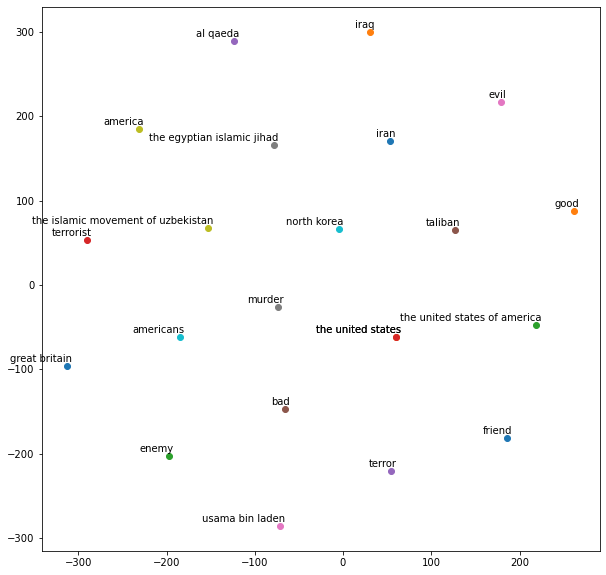

In [10]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
%matplotlib inline

def tsne_plot(model, set_array):
    "Creates and TSNE model and plots it"
    labels = []
    tokens = []

    print('creating tokens and labels')
#     for word in model.wv.key_to_index:
#         tokens.append(model.wv[word])
#         labels.append(word)
    
    set_array = [token.lower() for token in set_array]
    
    for word in set_array:
        if word in model.wv.index_to_key:
            tokens.append(model.wv[word])
            labels.append(word)
    
    
    print('building tsne model')
    tsne_model = TSNE(perplexity=40, n_components=2, init='pca', n_iter=2500, random_state=23)
    new_values = tsne_model.fit_transform(tokens)
    
    print('constructing graph')
    x = []
    y = []
    for value in new_values:
        x.append(value[0])
        y.append(value[1])
        
    plt.figure(figsize=(10, 10)) 
    for i in range(len(x)):
        plt.scatter(x[i],y[i])
        
        if labels[i] in set_array:
            plt.annotate(labels[i],
                xy=(x[i], y[i]),
                xytext=(5, 2),
                textcoords='offset points',
                ha='right',
                va='bottom')
            
    plt.savefig('vector_distribution.png')
    plt.show()
    
terms = seed_terms + ingroups + outgroups
tsne_plot(model, terms)

creating tokens and labels
building tsne model
constructing graph


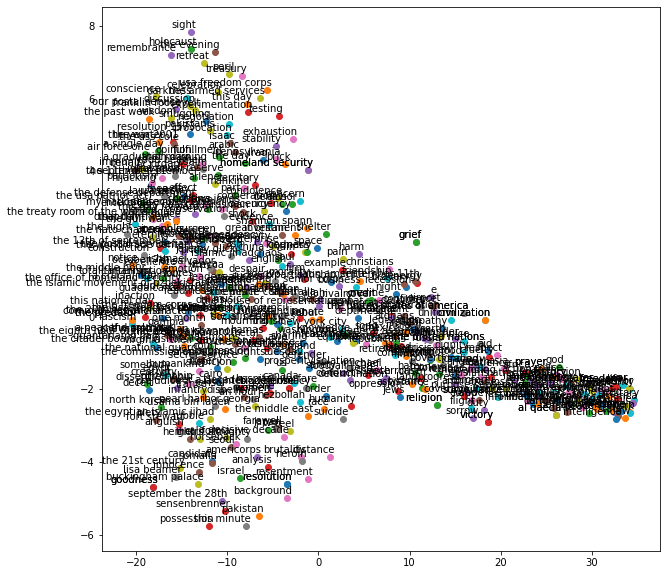

In [11]:
terms = set([span.text for span in doc.noun_chunks])
tsne_plot(model, terms)

In [12]:
outgroups = ['Taliban', 'al Qaeda']
seed_terms = ['terrorist', 'terror', 'murder', 'regime']
    
def get_word_contexts(iterable, terms_of_interest, seed_terms):
    
    for sentence in iterable:
    
        for term in terms_of_interest:

            term = term.lower()

            if term in sentence:

                index = sentence.index(term)

                if index - 5 >= 0:
                    left = index - 5
                else:
                    left = 0

                if index + 5 <= len(sentence):
                    right = index + 5
                else:
                    right = len(sentence)
                    
                new_sent = [token for token in sentence[left : right]]
                
                for seed_term in seed_terms:
                    new_sent.insert(0, seed_term in new_sent)
                    break
                    
                yield new_sent
                
with pd.option_context('display.max_rows', 100, 'display.max_colwidth', None):
        
    display(pd.DataFrame(get_word_contexts(create_doc_array(doc), outgroups, seed_terms)).fillna(value=''))

,0,1,2,3,4,5,6,7,8,9,10
0,True,loosely,affiliate,terrorist,organization,know,al qaeda,,,,
1,False,al qaeda,terror,mafia,crime,,,,,,
2,False,al qaeda,great,influence,afghanistan,support,taliban,regime,control,country,
3,False,leadership,al qaeda,great,influence,afghanistan,support,,,,
4,False,large,source,humanitarian,aid,condemn,taliban,regime,,,
5,False,aid,abet,murder,taliban,regime,commit,murder,,,
6,False,tonight,the united states of america,make,following,demand,taliban,deliver,united states,authority,leader
7,False,taliban,deliver,united states,authority,leader,al qaeda,hide,land,,
8,False,taliban,act,act,immediately,,,,,,
9,False,war,terror,begin,al qaeda,end,,,,,


In [13]:
terms_array = [outgroups, ingroups, seed_terms_bad]


for terms in terms_array:
    data = {}
    for term in terms:
        data[term] = {}
        data[term]['Occurence count'] = doc.text.lower().count(term.lower())
    
    display(pd.DataFrame(data))

,Taliban,al Qaeda
Occurence count,25,16


,America,Americans,Great Britain,The United States,The United States of America,the United States
Occurence count,209,40,3,31,8,31


,enemy,terrorist,terror,bad,evil,murder
Occurence count,18,107,196,1,33,29
